# Inference of parameters (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given the full data (of classes S, Ia, Is) from a generated trajectory.


In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pyross
import time 

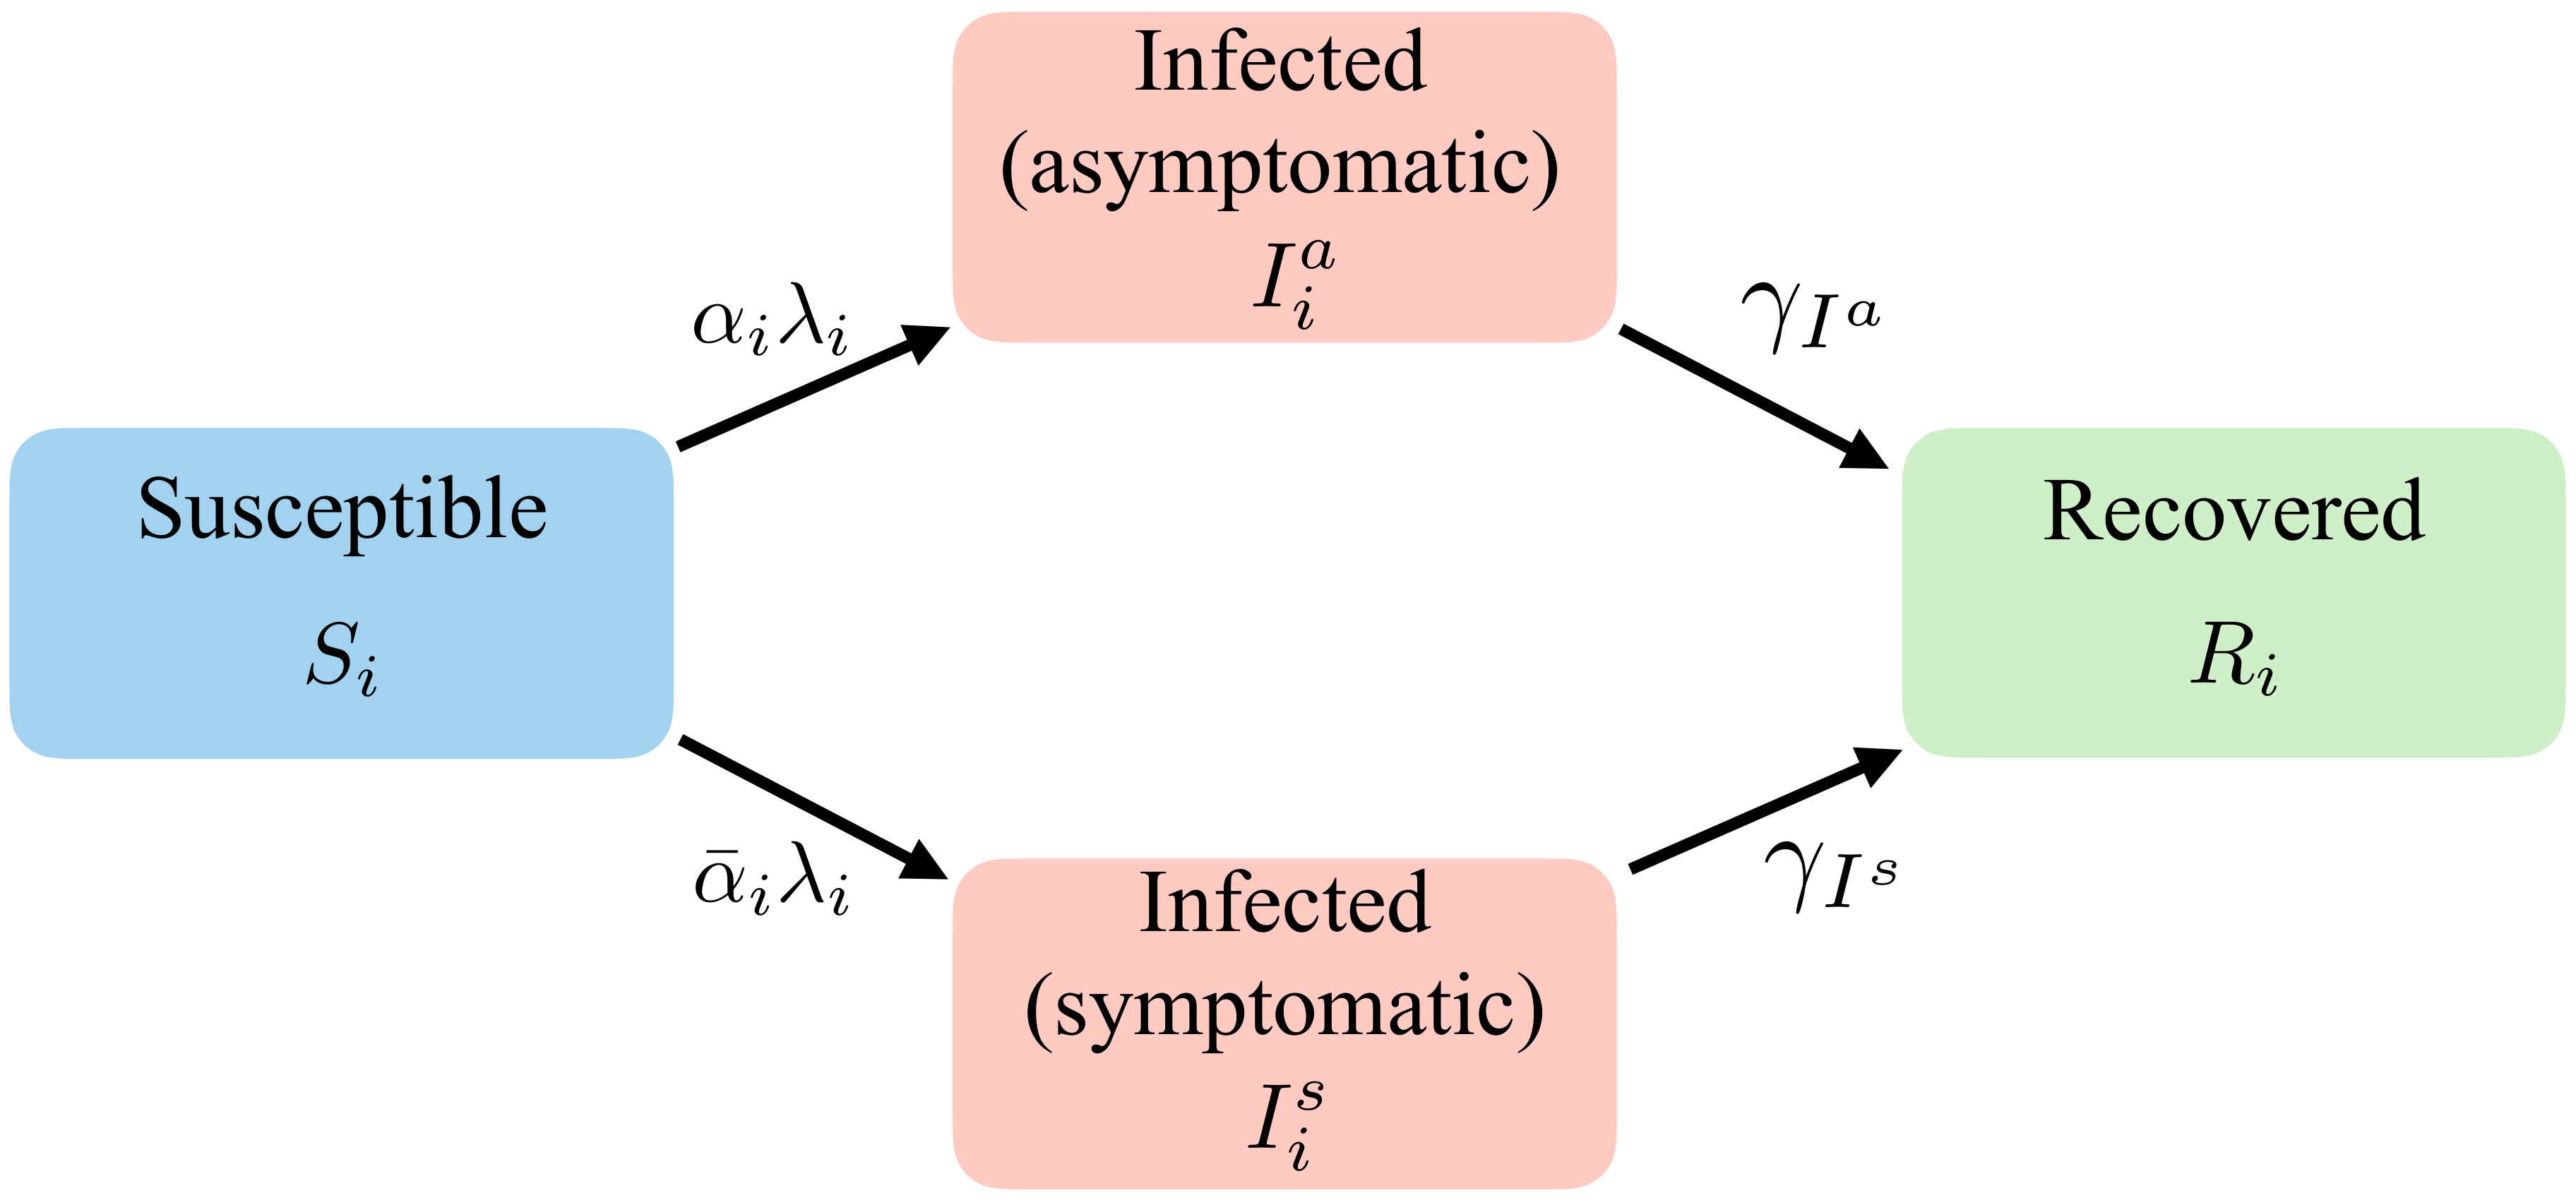

In [3]:
from IPython.display import Image
Image('SIIR.jpg')

## Denmark data

In [4]:
my_data = np.genfromtxt('../data/age_structures/Denmark-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;

M=16  ## number of age classes

Ni = Ni0[:M]
N=np.sum(Ni)

print("Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).")
print("Number of individuals in each bracket:")
print(Ni.astype('int'))
print("Total number of individuals: {0}".format(np.sum(Ni.astype('int'))))

Age groups are in brackets of 5 (i.e. 0-4, 5-9, 10-14, .. , 75-79).
Number of individuals in each bracket:
[302353 305513 338779 341219 379522 395469 342443 320132 366147 385944
 422585 381360 338039 319145 346572 220374]
Total number of individuals: 5505596


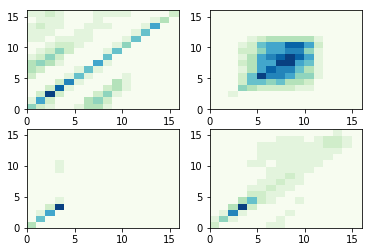

In [5]:
# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.Denmark()

# By default, home, work, school, and others contribute to the contact matrix
C = CH + CW + CS + CO

# Illustrate the individual contact matrices:
fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

C is the sum of contributions from contacts at home, workplace, schools and all other public spheres. Using superscripts $H$, $W$, $S$ and $O$ for each of these, we write the contact matrix as
$$
C_{ij} = C^H_{ij} + C^W_{ij} + C^S_{ij} + C^O_{ij}
$$

We read in these contact matrices from the data sets provided in the paper *Projecting social contact matrices in 152 countries using contact surveys and demographic data* by Prem et al, sum them to obtain the total contact matrix. We also read in the age distribution of UK obtained from the *Population pyramid* website.

In [6]:
import pandas as pd
denmark_age_structured_case = pd.read_csv('../data/covid-cases/denmark_cases_by_age.csv')

We will use the **infective number** for (52 days) for the initial conditions Is and Ia. 

In [7]:
## infective people
nbday = denmark_age_structured_case.shape[1]-1
nbgroup = denmark_age_structured_case.shape[0]
I = np.array(np.zeros([nbday, nbgroup-2]))
for i in range(1,nbday+1):
    I[i-1] = np.array([denmark_age_structured_case.iloc[:,i][:nbgroup-2]])
## we don't want a cum sum 
I[1:] -= I[:-1].copy()
I[3,0] = 1
##  duplicate for each subgroup of age 
M = 16
Is = np.array(np.zeros([nbday, M]))
for i in range(I.shape[0]):
    Is[i] = np.array([val for val in I[i]/2 for _ in (0, 1)])

## take only integer values, loosing cases !
for j in range(Is.shape[0]):
    Is[j] = np.array([int(i) for i in Is[j]])

In [8]:
Is.shape

(52, 16)

In [9]:
## Let's create 2 groups young/adults

In [10]:
Ismod = np.array(np.zeros([nbday, 3]))
for i in range(nbday):
    Ismod[i,0] = sum(Is[i,0:4])
    Ismod[i,1] = sum(Is[i,4:10])
    Ismod[i,2] = sum(Is[i,10:16])

In [11]:
## young 0-20 years
Is[,0:4]

SyntaxError: invalid syntax (<ipython-input-11-0365e4206451>, line 2)

In [12]:
## medium 20-50 years
Is[51,4:10]

array([10., 10., 14., 14., 10., 10.])

In [13]:
## senior 50-80 years
Is[51,10:16]

array([14., 14.,  7.,  7.,  2.,  2.])

In [14]:
## contact matrix
C.shape

(16, 16)

In [15]:
M=3

In [16]:
Cmod = np.array(np.zeros([3, 3]))
Cmod[0,0] = sum(C[0:4,0:4]).sum()
Cmod[0,1] = sum(C[0:4,4:10]).sum()
Cmod[0,2] = sum(C[0:4,10:16]).sum()
Cmod[1,0] = sum(C[4:10,0:4]).sum()
Cmod[1,1] = sum(C[4:10,4:10]).sum()
Cmod[1,2] = sum(C[4:10,10:16]).sum()
Cmod[2,0] = sum(C[10:16,0:4]).sum()
Cmod[2,1] = sum(C[10:16,4:10]).sum()
Cmod[2,2] = sum(C[10:16,10:16]).sum()


In [17]:
Cmod

array([[35.06507526, 16.69388143,  3.59720325],
       [17.05832189, 59.29966697, 11.25407257],
       [10.90584567, 24.61158764, 21.27748973]])

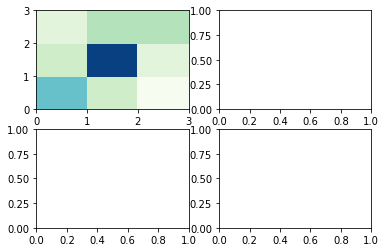

In [18]:
fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(Cmod, cmap=plt.cm.get_cmap('GnBu', 10));

In [19]:
Nimod = np.array(np.zeros([3]))
Nimod[0] = sum(Ni[0:4])
Nimod[1] =sum(Ni[4:10])
Nimod[2] =sum(Ni[10:16])

In [20]:
N=np.sum(Ni)

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [21]:
M =3
beta  = 0.036692            # infection rate 

gE    = 1/5.
gA    = 1/4.
gIa   = 1./3.                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
alpha = 0.4                 # fraction of asymptomatic infectives 
fsa   = 0.2    


# initial conditions    
Is0 = Ismod[0,]
Ia0 = Ismod[0,]
R0  = np.zeros((M))
S0  = Nimod - (Ia0 + Is0 + R0)

In [23]:
## matrix with all events
def contactMatrix(t):
    return Cmod

In [24]:
# fraction of population in Age group
fimod = Nimod/sum(Nimod)
Nimod = N*fimod

In [25]:
Nimod

array([1287864., 2189657., 2028075.])

## Model

In [26]:
Tf = 100
Nf = Tf+1

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

In [8]:
data_array = np.load('SIR_sto_traj.npy').astype('float')

In [5]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=2)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

NameError: name 'data' is not defined

<Figure size 800x640 with 0 Axes>

In [30]:
data_array

array([[1287784, 2188617, 2027651,      40,     520,     212,      40,
            520,     212],
       [ 639247,  400247,  786497,  244108,  665038,  465628,  366380,
         996600,  699059],
       [   9693,     113,    4602,  370749,  596450,  573772,  555548,
         892709,  860167],
       [    317,       0,      88,  268780,  427541,  412312,  402492,
         640041,  618262],
       [     29,       0,       5,  192815,  306894,  295298,  288124,
         459252,  442825],
       [      3,       0,       0,  138390,  219804,  211529,  206476,
         329425,  316886],
       [      1,       0,       0,   99008,  157197,  151572,  147859,
         236275,  227018],
       [      0,       0,       0,   70988,  112910,  108729,  105856,
         169216,  162572],
       [      0,       0,       0,   50897,   80599,   77815,   75747,
         121090,  116347],
       [      0,       0,       0,   36204,   57805,   55707,   54172,
          86897,   83332],
       [      0,    

In [ ]:
16*3

## 2) Inference
We take the first $20$ data points of the trajectories and use it to infer the parameters of the model.

In [32]:
# load the data and rescale to intensive variables 
Tf_inference = 150# truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

In [33]:
x = np.load('SIR_sto_traj.npy').astype('float')
steps = 101

In [35]:
## Is non cumulative - 52 days from the data
dayobs = 52
# x[:dayobs,3*M:4*M].shape
x[:dayobs,2*M:3*M] = Ismod

In [45]:
estimator

In [46]:
# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fimod, int(N), steps)

# # compute -log_p for the original (correct) parameters 
# start_time = time.time() 
# parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
# logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
# end_time = time.time()
# print(logp) 
# print(end_time - start_time)

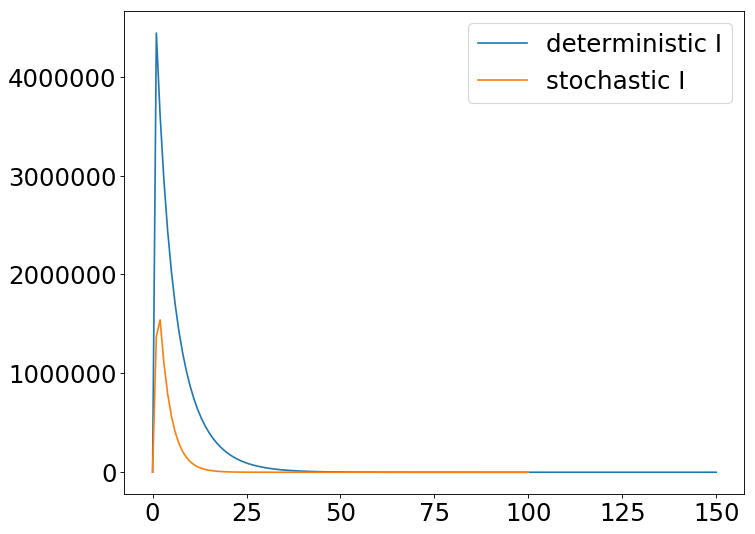

In [47]:
# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
x0=x[0]
det_model = pyross.deterministic.SIR(parameters, int(M), fimod)
xm = estimator.integrate(x[0], 0, Tf_inference, Nf_inference, det_model, contactMatrix)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(xm[:, M:], axis=1), label='deterministic I')
plt.plot(np.sum(x[:Nf_inference, M:], axis=1), label='stochastic I')
plt.legend()
plt.show()

In [49]:
# Define the prior (Gamma prior around guess of parameter with defined std. deviation)
alpha_g = 0.3
beta_g = 0.04
gIa_g = 0.1
gIs_g = 0.1


# compute -log_p for the initial guess 
# parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g, 'fsa':fsa}
# logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
# print(logp) 

In [50]:
eps = 1e-4 
# the names of the parameters to be inferred 
keys = ['alpha', 'beta', 'gIa', 'gIs']

# initial guess 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])  

# error bars on the initial guess 
alpha_std = 0.2
beta_std = 0.1
gIa_std = 0.1
gIs_std = 0.1
stds = np.array([alpha_std, beta_std , gIa_std, gIs_std])

# bounds on the parameters 
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)]) 

# Stopping criterion for minimisation (realtive change in function value)
ftol = 1e-6  
start_time = time.time() 
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf_inference, Nf_inference, 
                                    contactMatrix, 
                                    global_max_iter=20,
                                    local_max_iter=200, 
                                    global_ftol_factor=1e3, 
                                    ftol=ftol, 
                                    verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=2641228154, Fri May 15 15:34:12 2020)


Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.infere

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg

LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/pyth

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signatu

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
  File "/Users/in

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Traceback (most recent call last):


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", 

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.L

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, e

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
 

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/

LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Traceback (most recent call last):


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
   

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-pa

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.p

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", li

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlg

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
Traceback (most recent call last):


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular 

LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/nu

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
Traceback (most rec

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a,

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalge

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signat

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):


LinAlgError: Singular matrix

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):


LinAlgError: Singular matrix

Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in in

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=si

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
Traceback (

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise Lin

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):


LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):


LinAlgError: Singular matrix

Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signatu

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-package

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packag

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):


LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _um

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Traceback (most recent call last):


LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

Traceback (most recent call last):


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):


LinAlgError: Singular matrix

Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most 

LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551

LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgErr

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/nu

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):


LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/pyt

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlg

LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_adm

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/pyth

LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, si

LinAlgError: Singular matrix

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
Traceback (most recent call last):


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
  File "/Users/

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
Tracebac

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):


LinAlgError: Singular matrix

Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matri

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py"

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/l

LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
Traceback (most recent call last):


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most 

LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgE

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
Traceback (most recent call

LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):


LinAlgError: Singular matrix

Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgErr

LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):


LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/pyt

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):


LinAlgError: Singular matrix

Traceback (most recent call last):


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in in

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
    raise LinAlgError("Singular matrix")
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
Traceback (most recent call last):
numpy.linalg.LinAlgError: Singular matrix
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):


LinAlgError: Singular matrix

numpy.linalg.LinAlgError: Singular matrix
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    raise LinAlgError("Singular matrix")


LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular


LinAlgError: Singular matrix

    raise LinAlgError("Singular matrix")
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
numpy.linalg.LinAlgError: Singular matrix
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'


LinAlgError: Singular matrix

LinAlgError: Singular matrix

  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
Traceback (most recent call last):


LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Traceback (most recent call last):
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

LinAlgError: Singular matrix

Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 551, in inv


LinAlgError: Singular matrix

    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
Exception ignored in: 'pyross.inference.SIR_type.log_cond_p'
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
  File "/Users/ines_admin/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 97, in _raise_linalgerror_singular
Traceback (most recent call last):
    raise LinAlgError("Singular matrix")


In [32]:
# compute log_p for best estimate 
start_time = time.time() 
new_parameters = estimator.fill_params_dict(keys, params)
logp = estimator.obtain_minus_log_p(new_parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-892.6860202063925
0.14401507377624512


In [33]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(new_parameters)

True parameters:
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

Inferred parameters:
{'alpha': 0.17984873040810767, 'beta': 0.019797977148613668, 'gIa': 0.11270986709841756, 'gIs': 0.15345161478973068, 'fsa': 1}


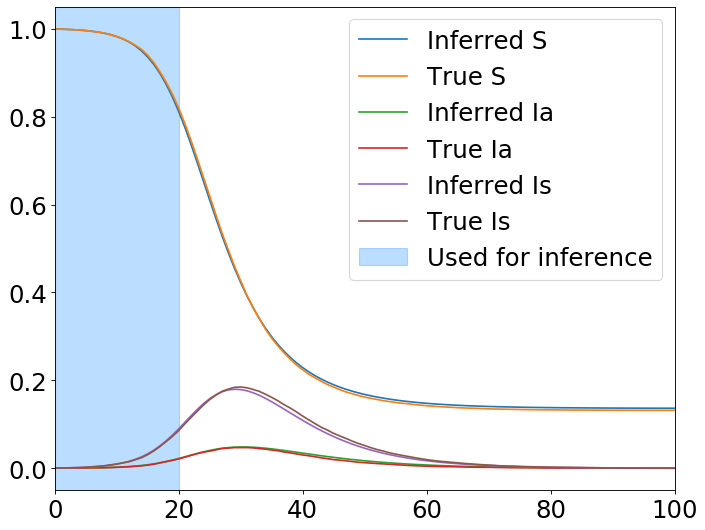

In [35]:
x = np.load('SIR_sto_traj.npy').astype('float')/N 
Nf = x.shape[0]
Tf = Nf-1

det_model = pyross.deterministic.SIR(new_parameters, int(M), fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Is')
plt.xlim([0, Tf])
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 